In [942]:
import pandas as pd
from collections import Counter
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils.genres import *
from src.utils.genres import name_plot, count_genre_over_years, top_years_for_genre, bottom_years_for_genre, count_genres_by_year, calc_genre_differences, calc_genre_growth, calc_proportion_growth
import warnings
import csv
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import ne_chunk
from nltk.sentiment import SentimentIntensityAnalyzer
from src.utils import google_trends as gt
warnings.simplefilter("ignore")
from scipy.signal import find_peaks

In [943]:
# Import data
data = pd.read_csv("data/data_Q1.csv")
df_wars = pd.DataFrame(data)
df_movies = pd.read_csv("data/filtered_movie_data.csv")

In [944]:
df_movies['Genres'] = df_movies['Genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
exploded_genres = df_movies.explode('Genres')
# Step 2: Get unique genres
unique_genres = exploded_genres['Genres'].unique()
# Step 3: Print the list of unique genres
#print(unique_genres)

# List of words/parts to search for in genres
search_terms = ["war", "spy", "patriot", "propagand", "hero", "social", "politic", "apocalyp", "topia"]

# Create a regex pattern to match any of the search terms
pattern = '|'.join(search_terms)  # Join terms with 'or' for regex

# Step 4: Filter genres that contain any of the specified words
matching_genres = [genre for genre in unique_genres if isinstance(genre, str) and pd.Series(genre).str.contains(pattern, case=False, na=False).any()]

# Step 5: Print the matching genres
print(matching_genres)


['War film', 'Political drama', 'Superhero movie', 'Spy', 'Political cinema', 'Dystopia', 'Political satire', 'Propaganda film', 'Social issues', 'Social problem film', 'Gulf War', 'Political thriller', 'Superhero', 'Apocalyptic and postapocalyptic fiction', 'Antiwar', 'Antiwar film', 'Glamorized Spy Film', 'Nuclear warfare', 'Cold War', 'War effort', 'Patriotic film', 'Political Documetary', 'The Netherlands in World War II']


In [945]:
def clean_genres(df_movies, genre_1, genre_2):
    # Convert the 'Genres' column from string to list (if it's in string format)
    df_movies['Genres'] = df_movies['Genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    
    # Step 2: Replace 'Superhero movie' with 'Superhero' and remove duplicates in each genre list
    df_movies['Genres'] = df_movies['Genres'].apply(lambda genres: list(set([genre if genre != genre_2 else genre_1 for genre in genres])))

    return df_movies

# Example of how to use it with your DataFrame:
df_movies = clean_genres(df_movies, "Superhero", "Superhero movie")
df_movies = clean_genres(df_movies, "Antiwar", "Antiwar film")
df_movies = clean_genres(df_movies, "Social issues", "Social problem film")
df_movies = clean_genres(df_movies, "Spy", "Glamorized Spy Film")

In [946]:
def analyze_genre_wars(df_movies, df_wars, genre_name):
    """
    Analyze the top 10 peak years for a given genre and find the relevant wars
    that occurred during ±2 years of those peak years.

    Parameters:
    - df_movies: DataFrame containing movie data with 'Year' and 'Genre'.
    - df_wars: DataFrame containing war data with 'StartYear', 'EndYear', and 'WarName'.
    - genre_name: The genre of films to analyze (e.g., "War film").
    """
    # Step 1: Count the number of films for the given genre
    genre_films = count_genre_over_years(df_movies, genre_name)

    # Step 2: Get the proportion of films for each year
    genre_films_proportion = count_genre_proportion(df_movies, genre_name)

    # Step 3: Plot the proportion of films for the genre over the years
    #sns.lineplot(data=genre_films_proportion, x="Year", y="Proportion")
    #name_plot(f"Proportion of {genre_name} Films Released", f"Proportion of {genre_name} Films Over the Years")

    # Step 6: Find the peaks in the proportion of films
    peak_indices, _ = find_peaks(genre_films_proportion["Proportion"])

    # Extract the peak years and corresponding values
    peak_years = genre_films_proportion.iloc[peak_indices]["Year"]
    peak_values = genre_films_proportion.iloc[peak_indices]["Proportion"]

    # Create a DataFrame of peaks
    peaks_df = pd.DataFrame({
        'Year': peak_years,
        'Proportion': peak_values
    })

    # Sort the peaks by Proportion in descending order and select the top 10
    top_peaks = peaks_df.sort_values(by="Proportion", ascending=False).head(10)

    # Extract top 10 peak years
    top_peak_years = top_peaks['Year'].values

    # Now, top_peak_years contains the top 10 peak years

    # Step 7: Define the time intervals for ±2 years around the peak years
    time_intervals = []
    for year in top_peak_years:
        start_year = year - 2
        end_year = year + 2
        time_intervals.append((start_year, end_year))

    # Step 8: Find the wars that happened during those time intervals
    wars_in_intervals = []
    unique_wars = set()  # Use a set to store unique war names

    for start_year, end_year in time_intervals:
        # Filter wars that started before or ended after the time interval
        relevant_wars = df_wars[
            (((start_year <= df_wars['StartYear']) & (df_wars['StartYear'] <= end_year)) |
             ((start_year <= df_wars['EndYear']) & (df_wars['EndYear'] <= end_year)) |
             ((df_wars['StartYear'] < start_year) & (df_wars["EndYear"] > end_year)))
        ]

        for _, war in relevant_wars.iterrows():
            if war['WarName'] not in unique_wars:
                unique_wars.add(war['WarName'])
                
                # Find the closest peak year that fits in the ±2 interval
                peak_year_for_war = None
                for peak_year in top_peak_years:
                    if peak_year - 2 <= war['StartYear'] <= peak_year + 2 or peak_year - 2 <= war['EndYear'] <= peak_year + 2 or\
                    ((war['StartYear'] < peak_year - 2) & (war['EndYear'] > peak_year + 2)):
                        peak_year_for_war = peak_year
                        break

                # Append the war details with the corresponding peak year
                wars_in_intervals.append((war['StartYear'], war['EndYear'], war['WarName'], peak_year_for_war))

    # Step 10: Create a DataFrame to store the result and include peak year
    wars_in_intervals_df = pd.DataFrame(wars_in_intervals, columns=["Start Year", "End Year", "War Name", "Peak Year"])

    # Step 11: Print the final DataFrame
    return genre_films_proportion['Year'], genre_films_proportion['Proportion'],wars_in_intervals_df

In [947]:
print(count_genre_over_years(df_movies, "Patriotic film"))
print(count_genre_over_years(df_movies, "Nuclear warfare"))
print(count_genre_over_years(df_movies, "War effort"))
print(count_genre_over_years(df_movies, "Political Documetary"))

   Year  Count
0  1944      2
   Year  Count
0  1959      1
1  1984      1
   Year  Count
0  1943      1
   Year  Count
0  2004      1


In [948]:
inspected_genres = ["War film", "Spy", "Superhero", "Antiwar", "Social issues", "Political satire", "Political thriller", "Political cinema", "Political drama", "Dystopia", "Apocalyptic and postapocalyptic fiction"]
military_genres = ["War film", "Spy", "Superhero"]
military_and_antiwar = ["War film", "Spy", "Superhero", "Antiwar"]
reflecting_genres = ["Political satire", "Political thriller", "Political cinema", "Political drama"]
dystopian_genres = ["Dystopia", "Apocalyptic and postapocalyptic fiction"]

                   War Name  Mean Peak Year
0              World War II            1943
1                  Nomonhan            1940
2             First Kashmir            1945
3   Second Laotian, Phase 2            1966
4       Third Sino-Japanese            1943
5                 Iran-Iraq            1979
6            Second Kashmir            1964
7              Arab-Israeli            1947
8      Vietnam War, Phase 2            1964
9                  Cold War            1958
10            Russo-Finnish            1940
11                    Chaco            1930
12              Franco-Thai            1943
13              Changkufeng            1940


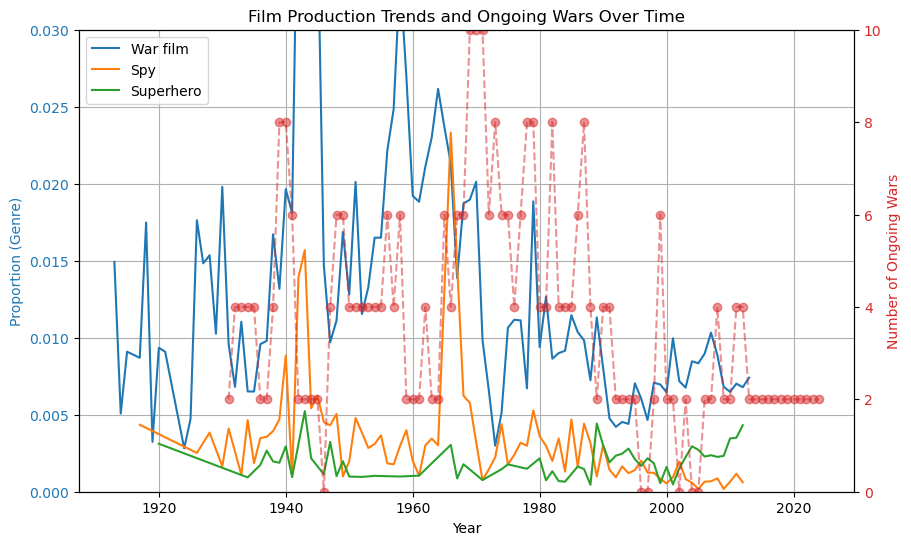

                  War Name  Mean Peak Year
0  Second Laotian, Phase 2            1966
1                Iran-Iraq            1979
2           Second Kashmir            1963
3     Vietnam War, Phase 2            1964
4                 Cold War            1958


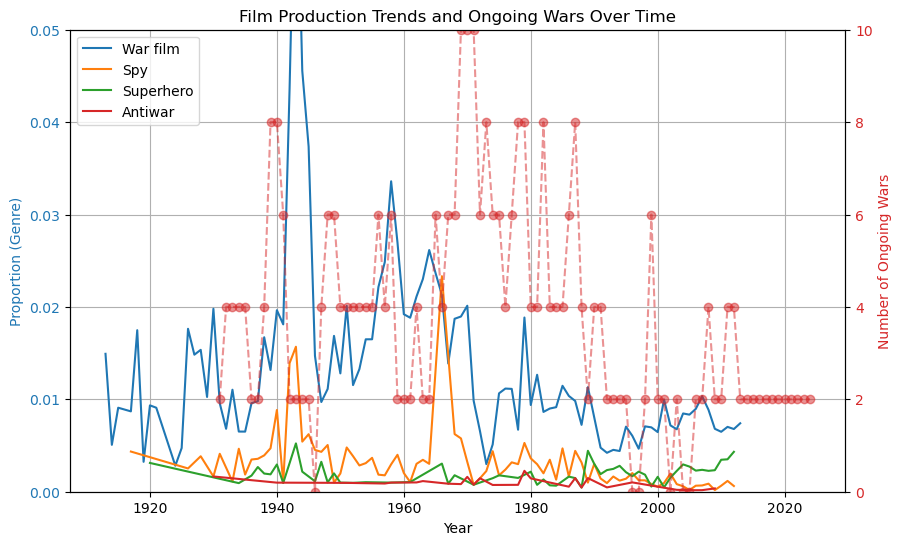

                    War Name  Mean Peak Year
0           Falkland Islands            1980
1      Bangladesh Liberation            1971
2           War over Lebanon            1980
3    Second Laotian, Phase 2            1968
4         Ugandian-Tanzanian            1976
5                  Iran-Iraq            1979
6        Communist Coalition            1968
7       Vietnam War, Phase 2            1968
8                   Cold War            1968
9              Turco-Cypriot            1972
10            Azeri-Armenian            1992
11  Sino-Vietnamese Punitive            1979
12            Yom Kippur War            1971
13              Badme Border            1997
14      Vietnamese-Cambodian            1976


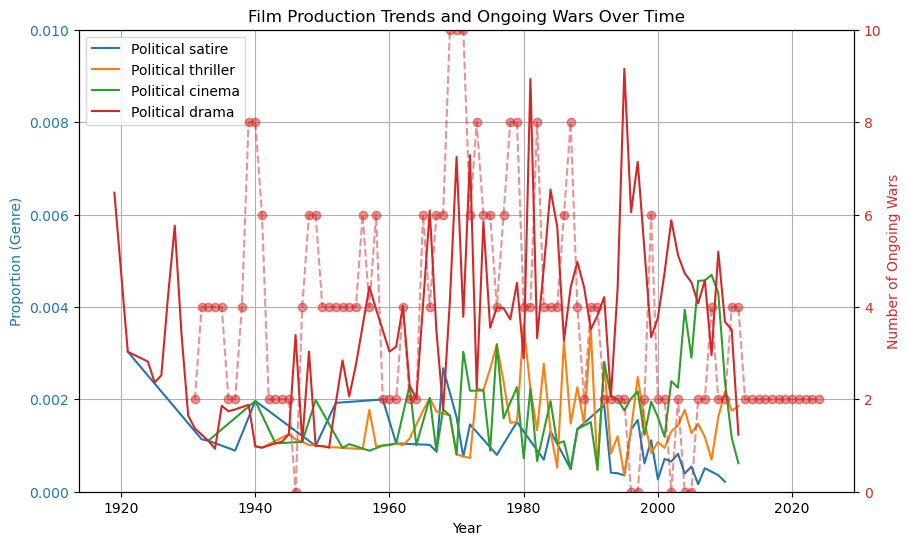

                   War Name  Mean Peak Year
0             Cenepa Valley            1993
1     Bangladesh Liberation            1971
2   Second Laotian, Phase 2            1973
3                 Iran-Iraq            1985
4           War over Angola            1973
5       Communist Coalition            1971
6      Gaza-Israel conflict            2005
7      Vietnam War, Phase 2            1973
8                  Cold War            1973
9             Turco-Cypriot            1973
10           Azeri-Armenian            1993
11           Yom Kippur War            1973
12                    Assam            1960


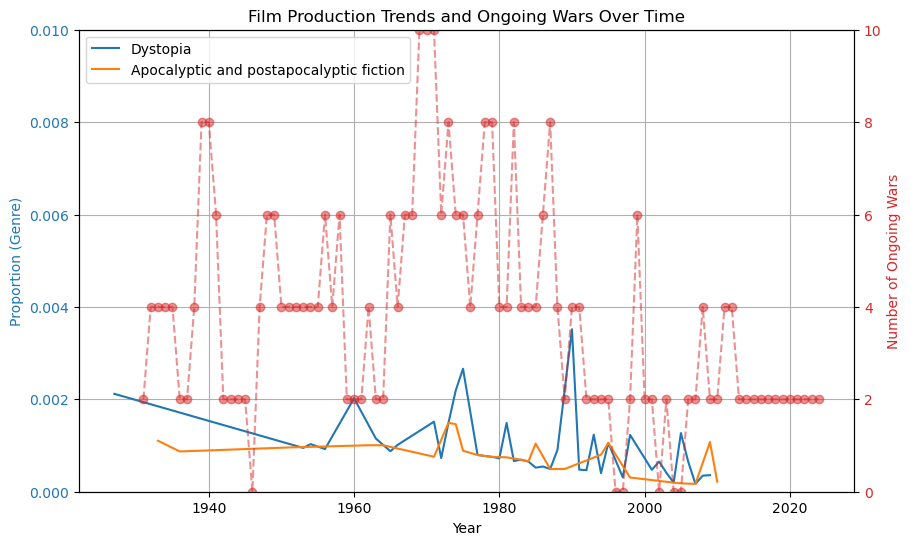

In [949]:
'''
def count_ongoing_wars(df_wars):
    # Get the range of years from the StartYear to the EndYear
    years = pd.Series(range(df_wars['StartYear'].min(), df_wars['EndYear'].max() + 1), name="Year")
    
    # Initialize a list to store the count of ongoing wars for each year
    ongoing_wars_count = []
    
    # Iterate over each year in the range
    for year in years:
        # Count the number of wars that are ongoing in this year
        ongoing_wars = df_wars[(df_wars['StartYear'] <= year) & (df_wars['EndYear'] >= year)]
        ongoing_wars_count.append(len(ongoing_wars))  # Store the count of ongoing wars for this year
    
    # Create a DataFrame with the year and the corresponding count of ongoing wars
    ongoing_wars_df = pd.DataFrame({'Year': years, 'Ongoing Wars': ongoing_wars_count})
    
    return ongoing_wars_df

ongoing_wars = count_ongoing_wars(df_wars)
data = ongoing_wars['Ongoing Wars'].values.reshape(1, -1)

# Plot the heatmap
plt.figure(figsize=(10, 6))  # Create a wide figure for better readability
plt.plot(ongoing_wars['Year'], ongoing_wars['Ongoing Wars'], marker='o', color='b', label='Ongoing Wars')

# Set labels and title
plt.title('Heatmap of Ongoing Wars Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Ongoing Wars')
plt.xlim(1910, 2015)

def inspect_peaks_events(genre_list, ylim):
    plt.figure(figsize=(10, 6))
    peak_wars = []
    # Loop through genres and plot them on the same plot
    for genre in genre_list:
        # Call the analyze_genre_wars function for the current genre, which now returns data
        genre_data = analyze_genre_wars(df_movies, df_wars, genre)
        
        # Plot each genre's data on the same axes
        plt.plot(genre_data[0], genre_data[1],label=f"{genre}")

        peak_wars.append(genre_data[2][["War Name", "Peak Year"]])
    plt.title('Film Production Trends for Different Genres')
    plt.xlabel('Year')
    plt.ylabel('Proportion')
    plt.ylim(0, ylim)
    plt.legend()
    plt.grid(True)
    
    intersection = set(peak_wars[0]['War Name'])  # Start with the "War Name" from the first genre
    
    for genre_data in peak_wars[1:]:
        intersection = intersection.intersection(set(genre_data['War Name']))

    # Filter each genre data to include only the intersected "War Name"
    filtered_peak_wars = []
    for genre_data in peak_wars:
        filtered_peak_wars.append(genre_data[genre_data['War Name'].isin(intersection)])

    # Step 1: Create a DataFrame to store the intersected "War Name" and the mean "Peak Year" values
    mean_values = []

    # Iterate through the filtered data frames and compute the mean for each "War Name"
    for war_name in intersection:
        # Collect Peak Year values for the intersecting War Name from each genre
        peak_years = [genre_data[genre_data['War Name'] == war_name]['Peak Year'].values[0] for genre_data in filtered_peak_wars]
        
        # Compute the mean for the Peak Year values for this War Name
        mean_peak_year = min(peak_years)
        
        # Store the results (War Name and Mean Peak Year)
        mean_values.append({"War Name": war_name, "Mean Peak Year": mean_peak_year})

    # Convert the mean values to a DataFrame
    mean_df = pd.DataFrame(mean_values)

    for _, row in mean_df.iterrows():
        plt.axvline(x=row['Mean Peak Year'], color='red', linestyle='--', label=f"Mean Peak Year for {row['War Name']}")
# Print the DataFrame with the mean values for inspection
    print(mean_df)

    # Display the plot with the heatmap and vertical lines
    plt.show()
'''
def count_ongoing_wars(df_wars):
    # Get the range of years from the StartYear to the EndYear
    years = pd.Series(range(df_wars['StartYear'].min(), df_wars['EndYear'].max() + 1), name="Year")
    
    # Initialize a list to store the count of ongoing wars for each year
    ongoing_wars_count = []
    
    # Iterate over each year in the range
    for year in years:
        # Count the number of wars that are ongoing in this year
        ongoing_wars = df_wars[(df_wars['StartYear'] <= year) & (df_wars['EndYear'] >= year)]
        ongoing_wars_count.append(len(ongoing_wars))  # Store the count of ongoing wars for this year
    
    # Create a DataFrame with the year and the corresponding count of ongoing wars
    ongoing_wars_df = pd.DataFrame({'Year': years, 'Ongoing Wars': ongoing_wars_count})
    
    return ongoing_wars_df

def inspect_peaks_events(genre_list, ylim):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    peak_wars = []
    
    # Loop through genres and plot them on the same plot (Primary Y-Axis)
    for genre in genre_list:
        # Call the analyze_genre_wars function for the current genre, which now returns data
        genre_data = analyze_genre_wars(df_movies, df_wars, genre)
        
        # Plot each genre's data on the primary axes
        ax1.plot(genre_data[0], genre_data[1], label=f"{genre}")

        peak_wars.append(genre_data[2][["War Name", "Peak Year"]])

    ax1.set_title('Film Production Trends and Ongoing Wars Over Time')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Proportion (Genre)', color='tab:blue')
    ax1.set_ylim(0, ylim)
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True)

    # Calculate the intersection of "War Name" across all genres
    intersection = set(peak_wars[0]['War Name'])  # Start with the "War Name" from the first genre
    
    for genre_data in peak_wars[1:]:
        intersection = intersection.intersection(set(genre_data['War Name']))

    # Filter each genre data to include only the intersected "War Name"
    filtered_peak_wars = []
    for genre_data in peak_wars:
        filtered_peak_wars.append(genre_data[genre_data['War Name'].isin(intersection)])

    # Step 1: Create a DataFrame to store the intersected "War Name" and the mean "Peak Year" values
    mean_values = []

    # Iterate through the filtered data frames and compute the mean for each "War Name"
    for war_name in intersection:
        # Collect Peak Year values for the intersecting War Name from each genre
        peak_years = [genre_data[genre_data['War Name'] == war_name]['Peak Year'].values[0] for genre_data in filtered_peak_wars]
        
        # Compute the mean for the Peak Year values for this War Name
        mean_peak_year = min(peak_years)
        
        # Store the results (War Name and Mean Peak Year)
        mean_values.append({"War Name": war_name, "Mean Peak Year": mean_peak_year})

    # Convert the mean values to a DataFrame
    mean_df = pd.DataFrame(mean_values)

    # Add vertical lines for each mean peak year
    #for _, row in mean_df.iterrows():
        #ax1.axvline(x=row['Mean Peak Year'], color='red', linestyle='--', label=f"Mean Peak Year for {row['War Name']}")

    # Print the DataFrame with the mean values for inspection
    print(mean_df)

    # Create the secondary y-axis for ongoing wars
    ax2 = ax1.twinx()

    # Calculate ongoing wars per year
    ongoing_wars_df = count_ongoing_wars(df_wars)

    # Plot the number of ongoing wars on the secondary y-axis
    ax2.plot(ongoing_wars_df['Year'], ongoing_wars_df['Ongoing Wars'], color='tab:red', label='Ongoing Wars', linestyle='--', marker='o', alpha = 0.5)

    ax2.set_ylabel('Number of Ongoing Wars', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.set_ylim(0, 10)

    # Add legends for both y-axes
    ax1.legend(loc='upper left')
    #ax2.legend(loc='upper right')

    # Display the plot
    plt.show()
inspect_peaks_events(military_genres, 0.03)
inspect_peaks_events(military_and_antiwar, 0.05)
inspect_peaks_events(reflecting_genres, 0.01)
inspect_peaks_events(dystopian_genres, 0.01)


                   War Name  Mean Peak Year
0              World War II            1943
1                  Nomonhan            1940
2             First Kashmir            1945
3   Second Laotian, Phase 2            1966
4       Third Sino-Japanese            1943
5                 Iran-Iraq            1979
6            Second Kashmir            1964
7              Arab-Israeli            1947
8      Vietnam War, Phase 2            1964
9                  Cold War            1958
10            Russo-Finnish            1940
11                    Chaco            1930
12              Franco-Thai            1943
13              Changkufeng            1940
Correlation between Ongoing Wars and War Film Peaks: -0.005102622299621573


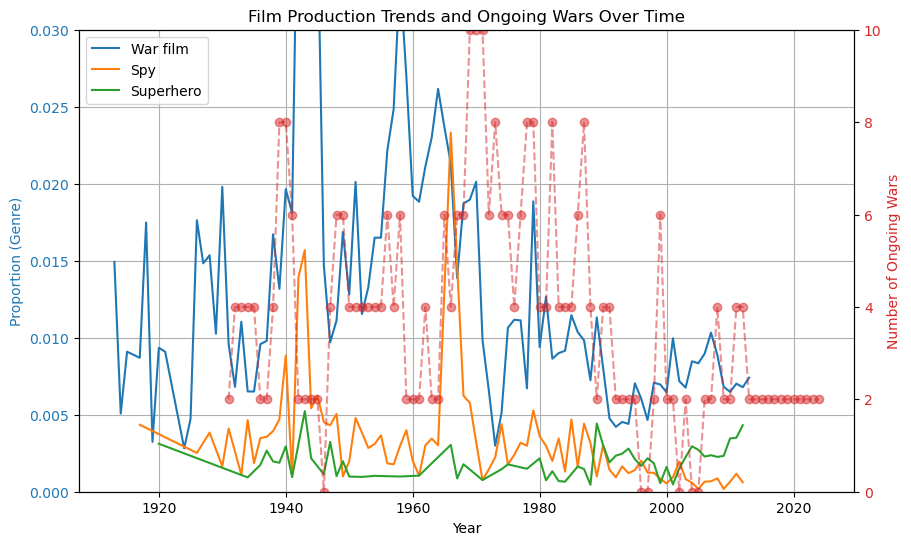

                  War Name  Mean Peak Year
0  Second Laotian, Phase 2            1966
1                Iran-Iraq            1979
2           Second Kashmir            1963
3     Vietnam War, Phase 2            1964
4                 Cold War            1958
Correlation between Ongoing Wars and War Film Peaks: 0.5623488691175613


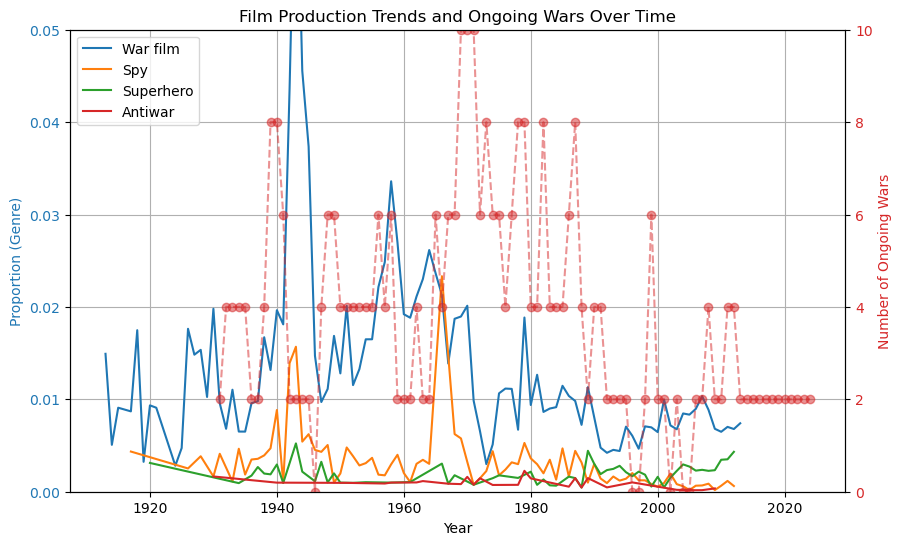

                    War Name  Mean Peak Year
0           Falkland Islands            1980
1      Bangladesh Liberation            1971
2           War over Lebanon            1980
3    Second Laotian, Phase 2            1968
4         Ugandian-Tanzanian            1976
5                  Iran-Iraq            1979
6        Communist Coalition            1968
7       Vietnam War, Phase 2            1968
8                   Cold War            1968
9              Turco-Cypriot            1972
10            Azeri-Armenian            1992
11  Sino-Vietnamese Punitive            1979
12            Yom Kippur War            1971
13              Badme Border            1997
14      Vietnamese-Cambodian            1976
Correlation between Ongoing Wars and War Film Peaks: -0.6910444595413126


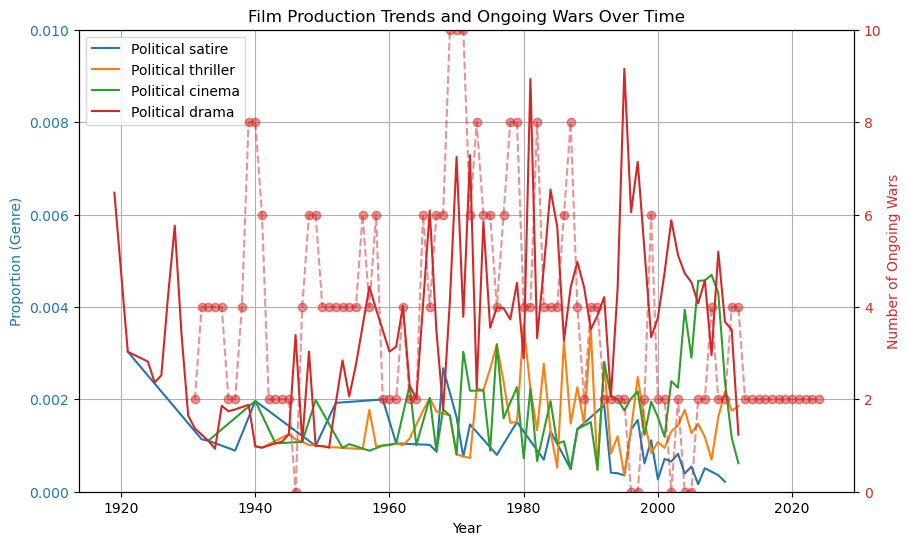

                   War Name  Mean Peak Year
0             Cenepa Valley            1993
1     Bangladesh Liberation            1971
2   Second Laotian, Phase 2            1973
3                 Iran-Iraq            1985
4           War over Angola            1973
5       Communist Coalition            1971
6      Gaza-Israel conflict            2005
7      Vietnam War, Phase 2            1973
8                  Cold War            1973
9             Turco-Cypriot            1973
10           Azeri-Armenian            1993
11           Yom Kippur War            1973
12                    Assam            1960
Correlation between Ongoing Wars and War Film Peaks: -0.6678801573344454


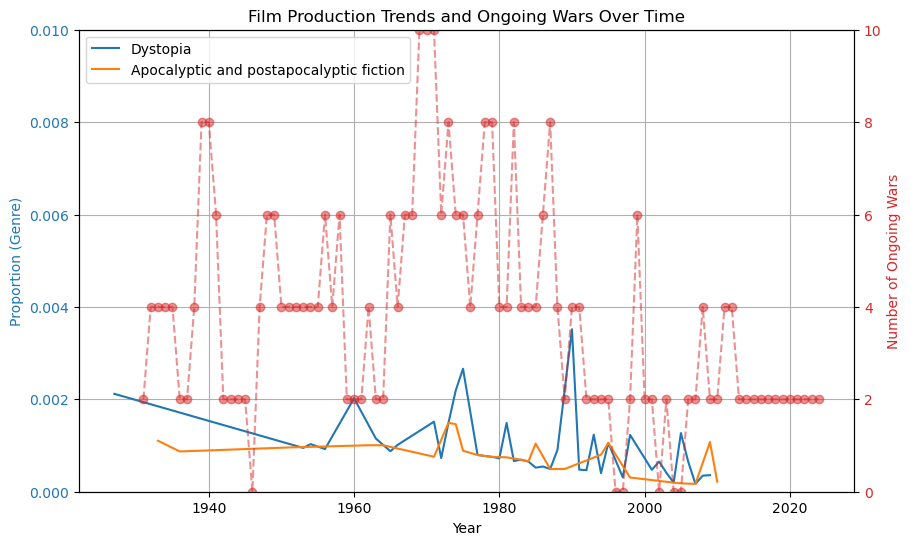

In [950]:
def count_ongoing_wars(df_wars):
    years = pd.Series(range(df_wars['StartYear'].min(), df_wars['EndYear'].max() + 1), name="Year")
    ongoing_wars_count = []
    
    for year in years:
        ongoing_wars = df_wars[(df_wars['StartYear'] <= year) & (df_wars['EndYear'] >= year)]
        ongoing_wars_count.append(len(ongoing_wars))  # Store the count of ongoing wars for this year
    
    ongoing_wars_df = pd.DataFrame({'Year': years, 'Ongoing Wars': ongoing_wars_count})
    
    return ongoing_wars_df

# Function to calculate the correlation and inspect peaks events
def inspect_peaks_events(genre_list, ylim):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    peak_wars = []
    
    # Loop through genres and plot them on the same plot (Primary Y-Axis)
    for genre in genre_list:
        genre_data = analyze_genre_wars(df_movies, df_wars, genre)
        ax1.plot(genre_data[0], genre_data[1], label=f"{genre}")
        peak_wars.append(genre_data[2][["War Name", "Peak Year"]])
    
    ax1.set_title('Film Production Trends and Ongoing Wars Over Time')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Proportion (Genre)', color='tab:blue')
    ax1.set_ylim(0, ylim)
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True)

    # Calculate the intersection of "War Name" across all genres
    intersection = set(peak_wars[0]['War Name'])
    for genre_data in peak_wars[1:]:
        intersection = intersection.intersection(set(genre_data['War Name']))

    # Filter each genre data to include only the intersected "War Name"
    filtered_peak_wars = []
    for genre_data in peak_wars:
        filtered_peak_wars.append(genre_data[genre_data['War Name'].isin(intersection)])

    # Step 1: Create a DataFrame to store the intersected "War Name" and the mean "Peak Year" values
    mean_values = []
    for war_name in intersection:
        peak_years = [genre_data[genre_data['War Name'] == war_name]['Peak Year'].values[0] for genre_data in filtered_peak_wars]
        mean_peak_year = min(peak_years)
        mean_values.append({"War Name": war_name, "Mean Peak Year": mean_peak_year})

    mean_df = pd.DataFrame(mean_values)
    
    #for _, row in mean_df.iterrows():
        #ax1.axvline(x=row['Mean Peak Year'], color='red', linestyle='--', label=f"Mean Peak Year for {row['War Name']}")

    print(mean_df)

    # Create the secondary y-axis for ongoing wars
    ax2 = ax1.twinx()
    ongoing_wars_df = count_ongoing_wars(df_wars)
    ax2.plot(ongoing_wars_df['Year'], ongoing_wars_df['Ongoing Wars'], color='tab:red', linestyle='--', marker='o', alpha=0.5)
    ax2.set_ylabel('Number of Ongoing Wars', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.set_ylim(0, 10)

    # Calculate the correlation between Ongoing Wars and War Film Trends
    merged_df = pd.merge(ongoing_wars_df, mean_df, left_on='Year', right_on='Mean Peak Year', how='inner')
    correlation = merged_df['Ongoing Wars'].corr(merged_df['Mean Peak Year'])
    print(f"Correlation between Ongoing Wars and War Film Peaks: {correlation}")

    ax1.legend(loc='upper left')
    plt.show()

# Example usage (assuming df_wars and df_movies are available):
inspect_peaks_events(military_genres, 0.03)
inspect_peaks_events(military_and_antiwar, 0.05)
inspect_peaks_events(reflecting_genres, 0.01)
inspect_peaks_events(dystopian_genres, 0.01)

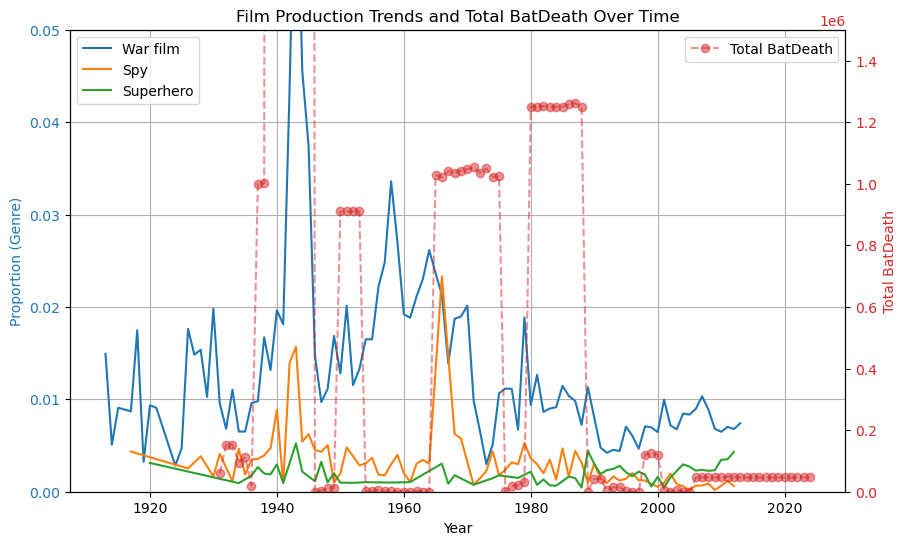

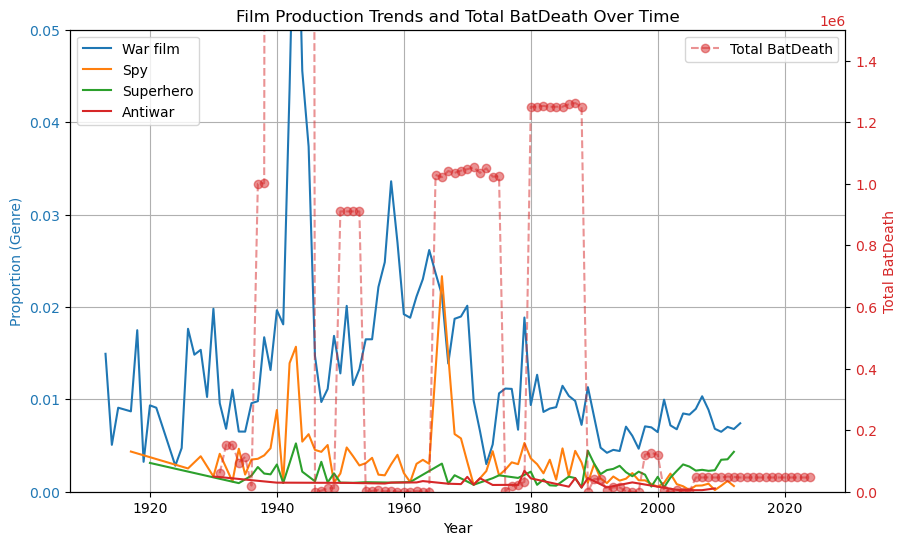

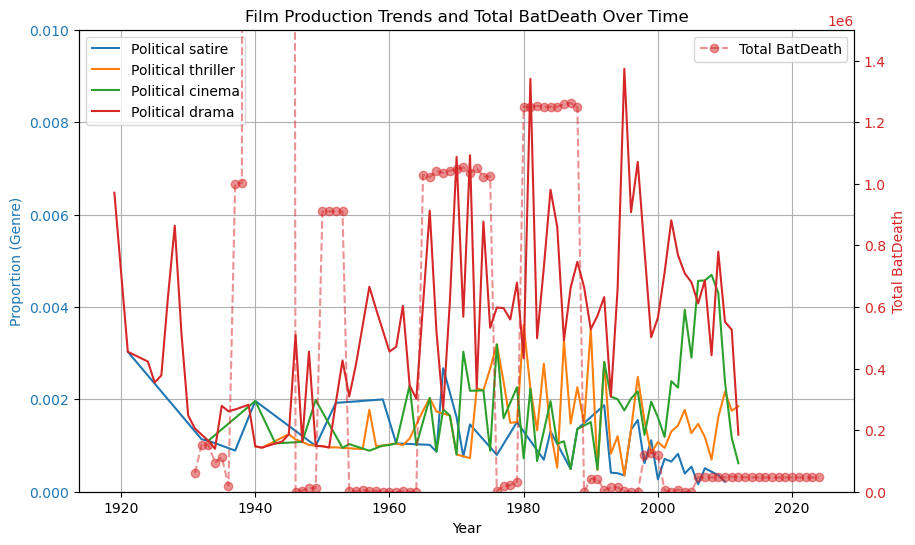

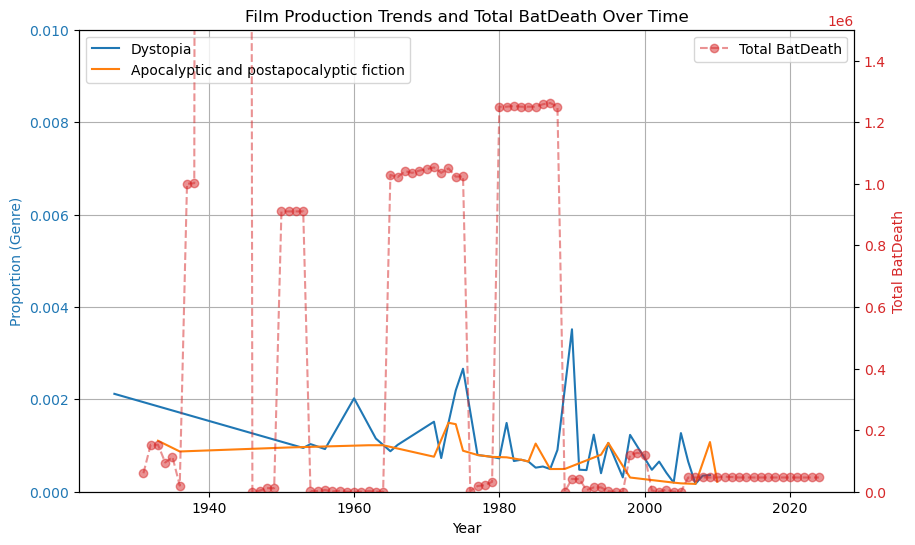

In [951]:
def calculate_total_batdeath_per_year():
    # Create a series of years from the minimum start year to the maximum end year
    years = pd.Series(range(df_wars['StartYear'].min(), df_wars['EndYear'].max() + 1), name="Year")
    
    # Initialize a list to store the summed BatDeath for each year
    total_batdeath_per_year = []
    
    # Iterate over each year in the range
    for year in years:
        total_batdeath = 0
        
        # Iterate over each war and check if it is ongoing during this year
        for _, row in df_wars.iterrows():
            start_year = row['StartYear']
            end_year = row['EndYear']
            batdeath = row['BatDeath']  # Use the BatDeath column from df_wars
            
            # Check if the war is ongoing during this year
            if start_year <= year <= end_year:
                total_batdeath += batdeath  # Add BatDeath for the ongoing war
        
        # Append the total BatDeath for this year
        total_batdeath_per_year.append(total_batdeath)
    
    # Create a DataFrame to hold the total BatDeath for each year
    total_batdeath_df = pd.DataFrame({'Year': years, 'Total BatDeath': total_batdeath_per_year})
    
    return total_batdeath_df

# Function to plot the genres and BatDeath data
def inspect_peaks_events_with_batdeath(genre_list, ylim):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    peak_wars = []
    
    # Loop through genres and plot them on the same plot (Primary Y-Axis)
    for genre in genre_list:
        # Call the analyze_genre_wars function for the current genre, which now returns data
        genre_data = analyze_genre_wars(df_movies, df_wars, genre)
        
        # Plot each genre's data on the primary axes
        ax1.plot(genre_data[0], genre_data[1], label=f"{genre}")

    ax1.set_title('Film Production Trends and Total BatDeath Over Time')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Proportion (Genre)', color='tab:blue')
    ax1.set_ylim(0, ylim)
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True)

    # Create the secondary y-axis for summed BatDeath
    ax2 = ax1.twinx()

    # Calculate the total BatDeath per year
    total_batdeath_df = calculate_total_batdeath_per_year()

    # Plot the summed BatDeath on the secondary y-axis
    ax2.plot(total_batdeath_df['Year'], total_batdeath_df['Total BatDeath'], color='tab:red', label='Total BatDeath', linestyle='--', marker='o', alpha=0.5)

    # Set the secondary y-axis label
    ax2.set_ylabel('Total BatDeath', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Set the limits for the secondary y-axis to start from 0
    ax2.set_ylim(0, 1.5*(10**6))  # Adding a small margin to the top

    # Add legends for both y-axes
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Display the plot
    plt.show()

inspect_peaks_events_with_batdeath(military_genres, 0.05)
inspect_peaks_events_with_batdeath(military_and_antiwar, 0.05)
inspect_peaks_events_with_batdeath(reflecting_genres, 0.01)
inspect_peaks_events_with_batdeath(dystopian_genres, 0.01)


Correlation between Total BatDeath and War Films: 0.2513626657422231


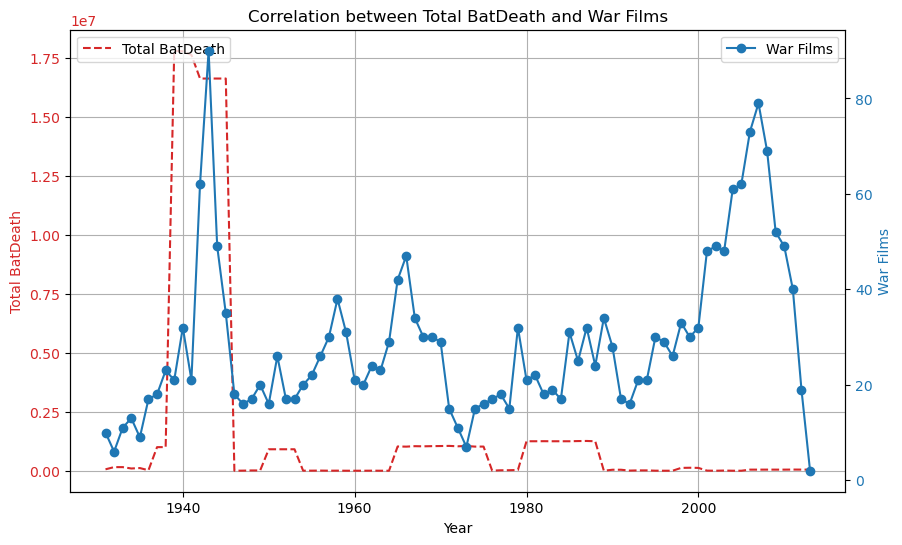

Correlation between Total BatDeath and War Films: 0.24544877698447895


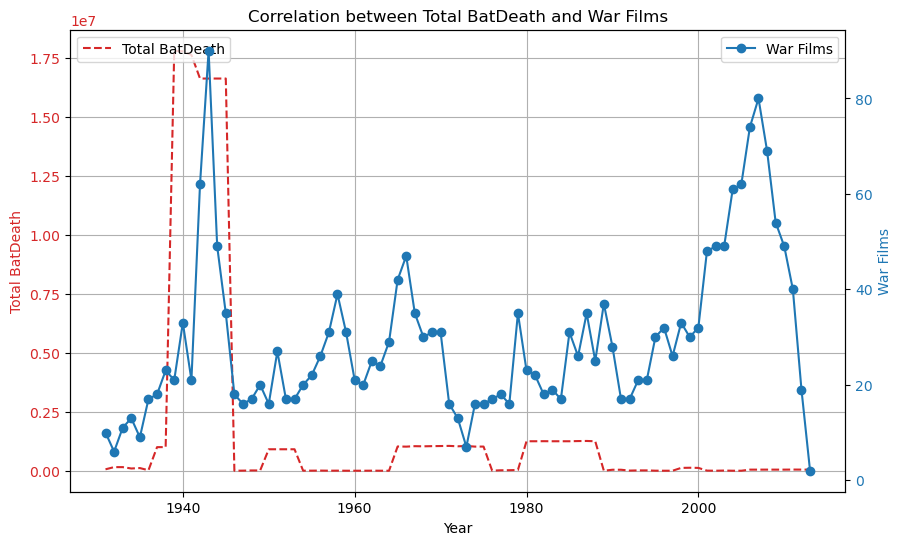

Correlation between Total BatDeath and War Films: -0.24241136649952613


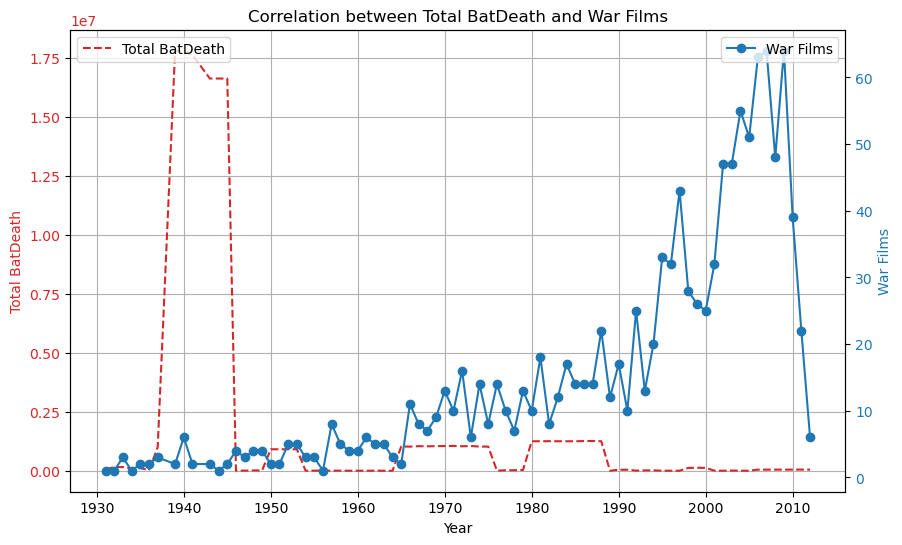

Correlation between Total BatDeath and War Films: -0.12056617228440675


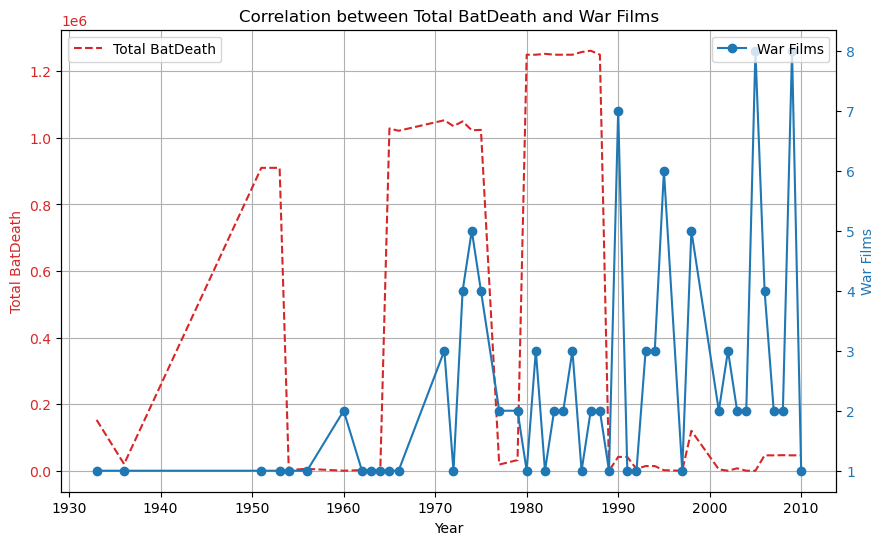

In [952]:
def calculate_total_batdeath_per_year(df_wars):
    years = pd.Series(range(df_wars['StartYear'].min(), df_wars['EndYear'].max() + 1), name="Year")
    total_batdeath_per_year = []

    for year in years:
        total_batdeath = 0
        for _, row in df_wars.iterrows():
            start_year = row['StartYear']
            end_year = row['EndYear']
            batdeath = row['BatDeath']
            
            if start_year <= year <= end_year:
                total_batdeath += batdeath  # Add BatDeath for the ongoing war
        
        total_batdeath_per_year.append(total_batdeath)

    total_batdeath_df = pd.DataFrame({'Year': years, 'Total BatDeath': total_batdeath_per_year})
    return total_batdeath_df

# Function to calculate the correlation between Total BatDeath and War Films
def calculate_correlation_with_batdeath(df_wars, df_movies, genre_list):
    # Initialize an empty list to accumulate War Film data for all genres
    all_war_films_data = []
    
    # Aggregate War Films data across all genres
    for genre in genre_list:
        war_films_df = count_genre_over_years(df_movies, genre)
        all_war_films_data.append(war_films_df)
    
    # Merge all genre data into one DataFrame
    merged_war_films_df = pd.concat(all_war_films_data, ignore_index=True)
    merged_war_films_df = merged_war_films_df.groupby('Year').sum().reset_index()  # Sum the counts by year

    # Get the total BatDeath per year
    total_batdeath_df = calculate_total_batdeath_per_year(df_wars)

    # Merge BatDeath and War Films data on 'Year'
    merged_df = pd.merge(total_batdeath_df, merged_war_films_df, on='Year', how='inner')

    # Calculate Pearson correlation between BatDeath and War Films
    correlation = merged_df['Total BatDeath'].corr(merged_df['Count'])
    
    return correlation, merged_df

# Function to plot the data with log scaling and show the correlation
def plot_with_batdeath_correlation(df_wars, df_movies, genre_list):
    correlation, merged_df = calculate_correlation_with_batdeath(df_wars, df_movies, genre_list)

    print(f"Correlation between Total BatDeath and War Films: {correlation}")
    
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot Total BatDeath on the primary axis
    ax1.plot(merged_df['Year'], merged_df['Total BatDeath'], label='Total BatDeath', color='tab:red', linestyle='--')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Total BatDeath', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    
    # Apply log scaling to the Total BatDeath axis
    #ax1.set_yscale('log')

    # Create secondary y-axis for War Films
    ax2 = ax1.twinx()
    ax2.plot(merged_df['Year'], merged_df['Count'], label='War Films', color='tab:blue', linestyle='-', marker='o')
    ax2.set_ylabel('War Films', color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # Apply log scaling to the War Films axis
    #ax2.set_yscale('log')

    ax1.grid(True)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    plt.title('Correlation between Total BatDeath and War Films')
    plt.show()

# Example usage (assuming df_wars and df_movies are available):
genre_lists = [
    military_genres,
    military_and_antiwar,
    reflecting_genres,
    dystopian_genres
]

# Run the analysis for each genre list
for genre_list in genre_lists:
    plot_with_batdeath_correlation(df_wars, df_movies, genre_list)

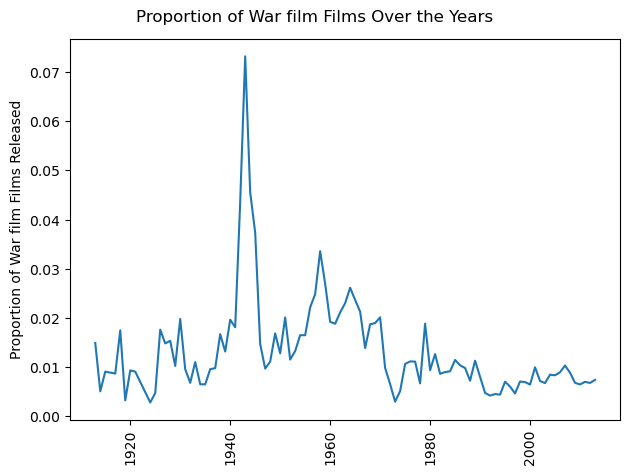

    Start Year  End Year                    War Name  Peak Year
0         1940      1941                 Franco-Thai       1943
1         1937      1941         Third Sino-Japanese       1943
2         1939      1945                World War II       1943
3         1947      1991                    Cold War       1958
4         1957      1958                     IfniWar       1958
5         1956      1956                   Sinai War       1958
6         1956      1956  Soviet Invasion of Hungary       1958
7         1958      1958              Taiwan Straits       1958
8         1962      1962                       Assam       1964
9         1965      1965              Second Kashmir       1964
10        1965      1975        Vietnam War, Phase 2       1964
11        1971      1971       Bangladesh Liberation       1970
12        1970      1971         Communist Coalition       1970
13        1969      1969                Football War       1970
14        1968      1973     Second Laot

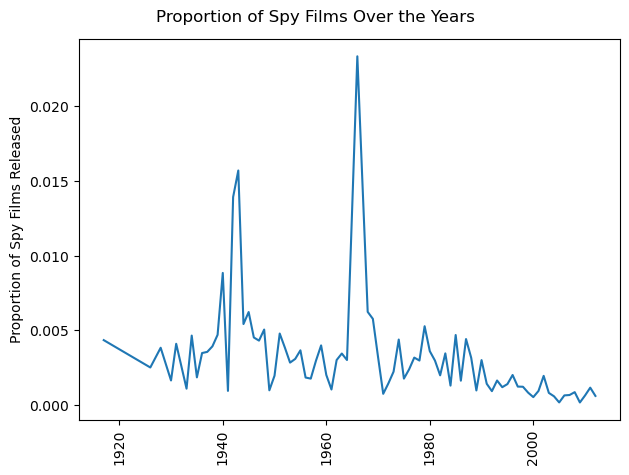

    Start Year  End Year                    War Name  Peak Year
0         1947      1991                    Cold War       1966
1         1965      1965              Second Kashmir       1966
2         1968      1973     Second Laotian, Phase 2       1966
3         1967      1967                 Six Day War       1966
4         1965      1975        Vietnam War, Phase 2       1966
5         1940      1941                 Franco-Thai       1943
6         1937      1941         Third Sino-Japanese       1943
7         1939      1945                World War II       1943
8         1938      1938                 Changkufeng       1940
9         1939      1939                    Nomonhan       1940
10        1939      1940               Russo-Finnish       1940
11        1947      1949               First Kashmir       1945
12        1980      1988                   Iran-Iraq       1979
13        1977      1978  Second Ogaden War, Phase 2       1979
14        1979      1979    Sino-Vietnam

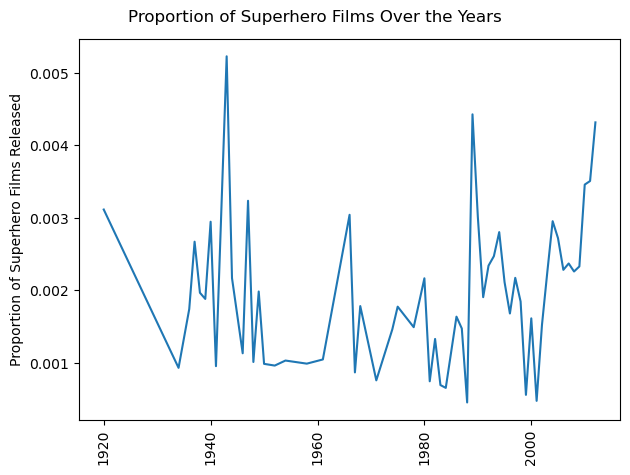

    Start Year  End Year                    War Name  Peak Year
0         1940      1941                 Franco-Thai       1943
1         1937      1941         Third Sino-Japanese       1943
2         1939      1945                World War II       1943
3         1947      1991                    Cold War       1989
4         1990      1991                    Gulf War       1989
5         1980      1988                   Iran-Iraq       1989
6         1987      1987  Sino-Vietnamese Border War       1989
7         1986      1987   War over the Aouzou Strip       1989
8         1948      1949                Arab-Israeli       1947
9         1947      1949               First Kashmir       1947
10        1965      1965              Second Kashmir       1966
11        1968      1973     Second Laotian, Phase 2       1966
12        1967      1967                 Six Day War       1966
13        1965      1975        Vietnam War, Phase 2       1966
14        2006      2024        Gaza-Isr

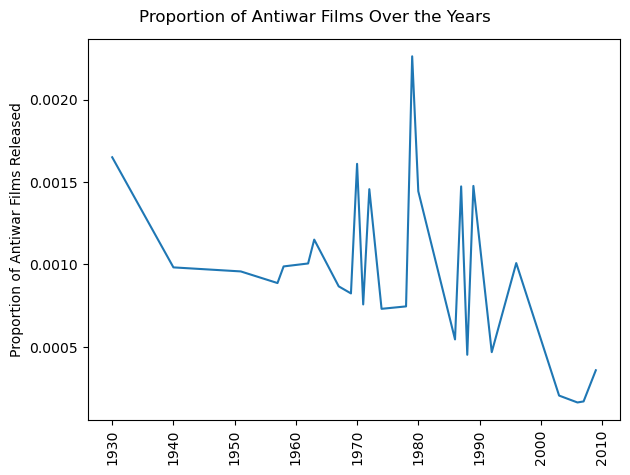

    Start Year  End Year                    War Name  Peak Year
0         1947      1991                    Cold War       1979
1         1980      1988                   Iran-Iraq       1979
2         1977      1978  Second Ogaden War, Phase 2       1979
3         1979      1979    Sino-Vietnamese Punitive       1979
4         1978      1979          Ugandian-Tanzanian       1979
5         1977      1979        Vietnamese-Cambodian       1979
6         1971      1971       Bangladesh Liberation       1970
7         1970      1971         Communist Coalition       1970
8         1969      1969                Football War       1970
9         1968      1973     Second Laotian, Phase 2       1970
10        1965      1975        Vietnam War, Phase 2       1970
11        1969      1970            War of Attrition       1970
12        1990      1991                    Gulf War       1989
13        1987      1987  Sino-Vietnamese Border War       1989
14        1986      1987   War over the 

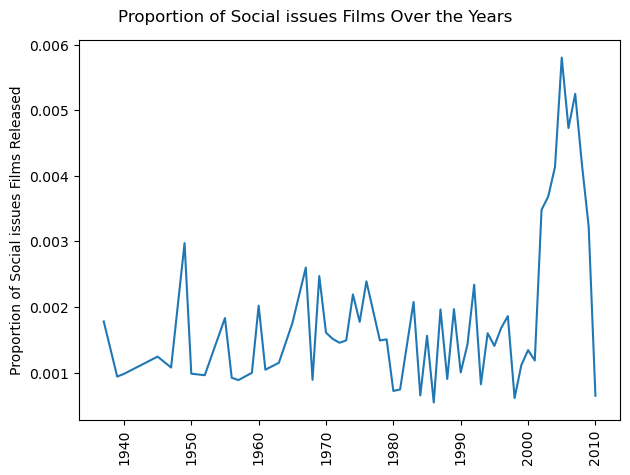

    Start Year  End Year                    War Name  Peak Year
0         2006      2024        Gaza-Israel conflict       2005
1         2003      2003            Invasion of Iraq       2005
2         2008      2008          Russo-Georgian War       2007
3         1948      1949                Arab-Israeli       1949
4         1947      1991                    Cold War       1949
5         1947      1949               First Kashmir       1949
6         1950      1953                      Korean       1949
7         1969      1969                Football War       1967
8         1965      1965              Second Kashmir       1967
9         1968      1973     Second Laotian, Phase 2       1967
10        1967      1967                 Six Day War       1967
11        1965      1975        Vietnam War, Phase 2       1967
12        1969      1970            War of Attrition       1967
13        1971      1971       Bangladesh Liberation       1969
14        1970      1971         Communi

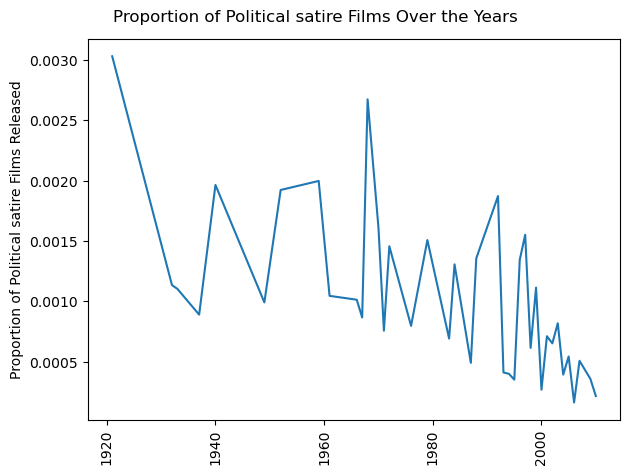

    Start Year  End Year                    War Name  Peak Year
0         1947      1991                    Cold War       1968
1         1970      1971         Communist Coalition       1968
2         1969      1969                Football War       1968
3         1968      1973     Second Laotian, Phase 2       1968
4         1967      1967                 Six Day War       1968
5         1965      1975        Vietnam War, Phase 2       1968
6         1969      1970            War of Attrition       1968
7         1957      1958                     IfniWar       1959
8         1958      1958              Taiwan Straits       1959
9         1938      1938                 Changkufeng       1940
10        1940      1941                 Franco-Thai       1940
11        1939      1939                    Nomonhan       1940
12        1939      1940               Russo-Finnish       1940
13        1937      1941         Third Sino-Japanese       1940
14        1939      1945                

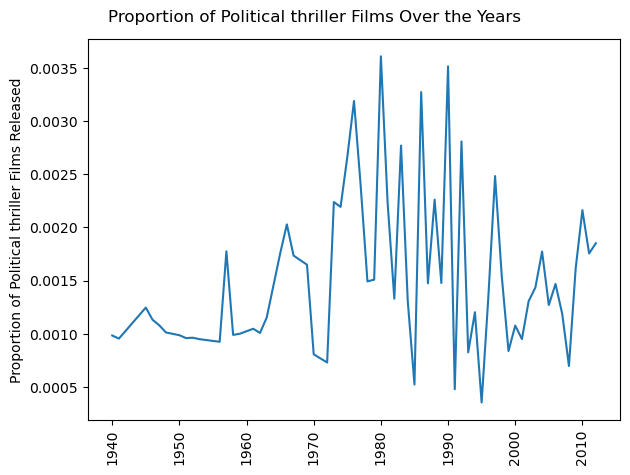

    Start Year  End Year                    War Name  Peak Year
0         1947      1991                    Cold War       1980
1         1982      1982            Falkland Islands       1980
2         1980      1988                   Iran-Iraq       1980
3         1977      1978  Second Ogaden War, Phase 2       1980
4         1979      1979    Sino-Vietnamese Punitive       1980
5         1978      1979          Ugandian-Tanzanian       1980
6         1977      1979        Vietnamese-Cambodian       1980
7         1982      1982            War over Lebanon       1980
8         1992      1992        Bosnian Independence       1990
9         1990      1991                    Gulf War       1990
10        1987      1987  Sino-Vietnamese Border War       1986
11        1986      1987   War over the Aouzou Strip       1986
12        1974      1974               Turco-Cypriot       1976
13        1965      1975        Vietnam War, Phase 2       1976
14        1975      1976             War

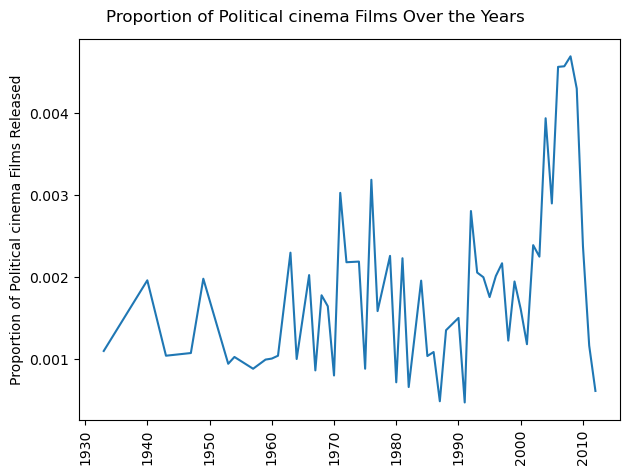

    Start Year  End Year                    War Name  Peak Year
0         2006      2024        Gaza-Israel conflict       2008
1         2008      2008          Russo-Georgian War       2008
2         2003      2003            Invasion of Iraq       2004
3         1947      1991                    Cold War       1976
4         1977      1978  Second Ogaden War, Phase 2       1976
5         1974      1974               Turco-Cypriot       1976
6         1978      1979          Ugandian-Tanzanian       1976
7         1965      1975        Vietnam War, Phase 2       1976
8         1977      1979        Vietnamese-Cambodian       1976
9         1975      1976             War over Angola       1976
10        1971      1971       Bangladesh Liberation       1971
11        1970      1971         Communist Coalition       1971
12        1969      1969                Football War       1971
13        1968      1973     Second Laotian, Phase 2       1971
14        1969      1970            War 

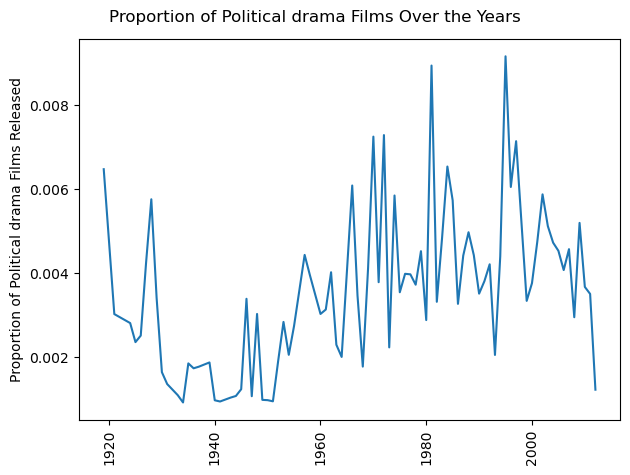

    Start Year  End Year                   War Name  Peak Year
0         1993      1994             Azeri-Armenian       1995
1         1995      1995              Cenepa Valley       1995
2         1947      1991                   Cold War       1981
3         1982      1982           Falkland Islands       1981
4         1980      1988                  Iran-Iraq       1981
5         1979      1979   Sino-Vietnamese Punitive       1981
6         1978      1979         Ugandian-Tanzanian       1981
7         1977      1979       Vietnamese-Cambodian       1981
8         1982      1982           War over Lebanon       1981
9         1971      1971      Bangladesh Liberation       1972
10        1970      1971        Communist Coalition       1972
11        1968      1973    Second Laotian, Phase 2       1972
12        1974      1974              Turco-Cypriot       1972
13        1965      1975       Vietnam War, Phase 2       1972
14        1969      1970           War of Attrition    

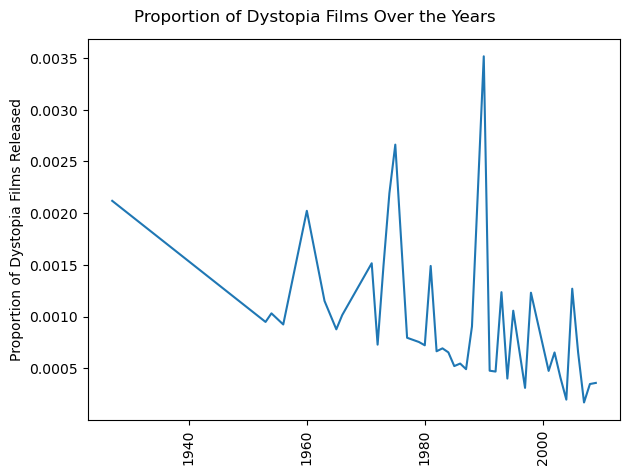

    Start Year  End Year                    War Name  Peak Year
0         1992      1992        Bosnian Independence       1990
1         1947      1991                    Cold War       1990
2         1990      1991                    Gulf War       1990
3         1980      1988                   Iran-Iraq       1990
4         1968      1973     Second Laotian, Phase 2       1975
5         1977      1978  Second Ogaden War, Phase 2       1975
6         1974      1974               Turco-Cypriot       1975
7         1965      1975        Vietnam War, Phase 2       1975
8         1977      1979        Vietnamese-Cambodian       1975
9         1975      1976             War over Angola       1975
10        1973      1973              Yom Kippur War       1975
11        1962      1962                       Assam       1960
12        1957      1958                     IfniWar       1960
13        1958      1958              Taiwan Straits       1960
14        1971      1971       Banglades

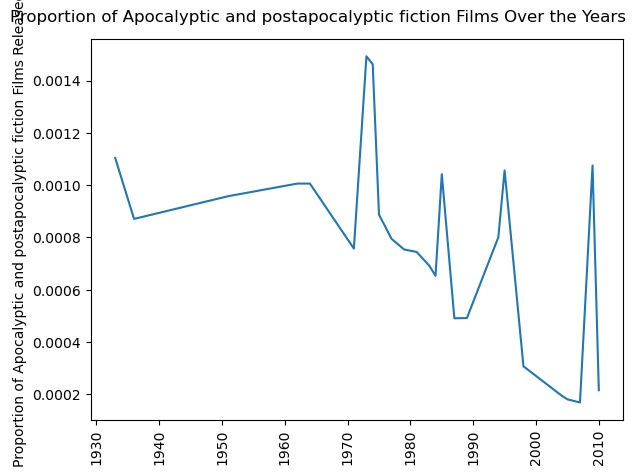

    Start Year  End Year                    War Name  Peak Year
0         1971      1971       Bangladesh Liberation       1973
1         1947      1991                    Cold War       1973
2         1970      1971         Communist Coalition       1973
3         1968      1973     Second Laotian, Phase 2       1973
4         1974      1974               Turco-Cypriot       1973
5         1965      1975        Vietnam War, Phase 2       1973
6         1975      1976             War over Angola       1973
7         1973      1973              Yom Kippur War       1973
8         2011      2011      First Libyan Civil War       2009
9         2006      2024        Gaza-Israel conflict       2009
10        2008      2008          Russo-Georgian War       2009
11        1993      1994              Azeri-Armenian       1995
12        1995      1995               Cenepa Valley       1995
13        1980      1988                   Iran-Iraq       1985
14        1987      1987  Sino-Vietnames

In [953]:
for genre in inspected_genres:
    x_val, y_val,df = analyze_genre_wars(df_movies, df_wars, genre)
    plt.plot(x_val, y_val)
    name_plot(f"Proportion of {genre} Films Released", f"Proportion of {genre} Films Over the Years")
    print(df)

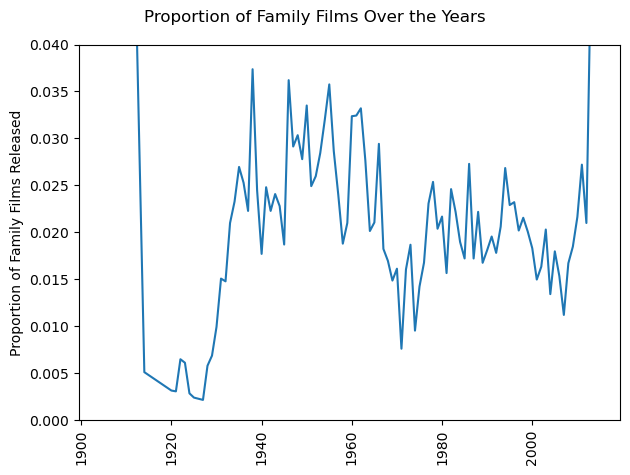

    Start Year  End Year                    War Name  Peak Year
0         1938      1938                 Changkufeng       1938
1         1935      1936        Conquest of Ethiopia       1938
2         1940      1941                 Franco-Thai       1938
3         1939      1939                    Nomonhan       1938
4         1939      1940               Russo-Finnish       1938
5         1937      1941         Third Sino-Japanese       1938
6         1939      1945                World War II       1938
7         1948      1949                Arab-Israeli       1946
8         1947      1991                    Cold War       1946
9         1947      1949               First Kashmir       1946
10        1957      1958                     IfniWar       1955
11        1950      1953                      Korean       1955
12        1954      1955           Off-shore Islands       1955
13        1956      1956                   Sinai War       1955
14        1956      1956  Soviet Invasio

In [954]:
plt.ylim(0, 0.04)
x_val, y_val, df = analyze_genre_wars(df_movies, df_wars, "Family Film")
plt.plot(x_val, y_val)
name_plot(f"Proportion of Family Films Released", f"Proportion of Family Films Over the Years")
print(df)